<h1> October VIX Analysis

<h3> Imports & Data Load

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from math import ceil
import warnings
warnings.filterwarnings("ignore")

# Regressions
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Reproducibility
np.random.seed(42)

# Load Bloomberg Terminal VIX price data
vix_data = pd.read_excel('data/vix_data_raw.xlsx')

# Clean column names
vix_data_clean = vix_data.rename(
    columns={"DATE": "Date", "OPEN": "Open", "HIGH": "High", "LOW": "Low", "CLOSE": "Close"}
)

# Parse dates and ensure numeric prices
vix_data_clean["Date"] = pd.to_datetime(vix_data_clean["Date"])
for c in ["Open", "High", "Low", "Close"]:
    vix_data_clean[c] = pd.to_numeric(vix_data_clean[c], errors="coerce")

# Keep, sort, and index data
vix_data_clean = vix_data_clean.dropna(subset=["Date", "Close"]).sort_values("Date").reset_index(drop=True)

# Confirm changes
print(vix_data_clean.dtypes)
print(vix_data_clean.head())

Date     datetime64[ns]
Open            float64
High            float64
Low             float64
Close           float64
dtype: object
        Date   Open   High    Low  Close
0 1990-01-02  17.24  17.24  17.24  17.24
1 1990-01-03  18.19  18.19  18.19  18.19
2 1990-01-04  19.22  19.22  19.22  19.22
3 1990-01-05  20.11  20.11  20.11  20.11
4 1990-01-08  20.26  20.26  20.26  20.26


<h3> October Return Methodology

For each calendar year, October return = % change from the last trading day of September close to last trading day of October close.

In [2]:
# Add Year/Month 
vix_data_clean["Year"]  = vix_data_clean["Date"].dt.year
vix_data_clean["Month"] = vix_data_clean["Date"].dt.month

# Pull last trading day close for each Year, Month
last_close = (
    vix_data_clean.sort_values("Date")
      .groupby(["Year", "Month"], as_index=False)
      .tail(1)[["Year", "Month", "Close"]]
      .rename(columns={"Close": "LastClose"})
)

# Pull September-end and October-end closes per year
september  = last_close[last_close["Month"] == 9 ][["Year", "LastClose"]].rename(columns={"LastClose": "SepEnd"})
october = last_close[last_close["Month"] == 10][["Year", "LastClose"]].rename(columns={"LastClose": "OctEnd"})

# Merge and compute October return
oct_returns = pd.merge(october, september, on="Year", how="inner")
oct_returns["OctReturn"] = (oct_returns["OctEnd"] - oct_returns["SepEnd"]) / oct_returns["SepEnd"]

# Clean columns
oct_returns = oct_returns[["Year", "OctReturn"]].sort_values("Year").reset_index(drop=True)

# Add election-year dummy
election_years = {1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020}
oct_returns["ElectionYear"] = oct_returns["Year"].isin(election_years).astype(int)

# Add September-end (lag) level as optional control
sep_levels = september.rename(columns={"SepEnd": "SepEndVIX"})[["Year", "SepEndVIX"]]
oct_returns = oct_returns.merge(sep_levels, on="Year", how="left")

oct_returns.head()

,Year,OctReturn,ElectionYear,SepEndVIX
0,1990,0.031948,0,29.11
1,1991,-0.023344,0,15.85
2,1992,0.130952,1,14.28
3,1993,-0.117783,0,12.99
4,1994,0.019608,0,14.28


<h3> October Bar Chart

Each bar represents a yearly October return; black for non-election years and yellow for election years (1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020).

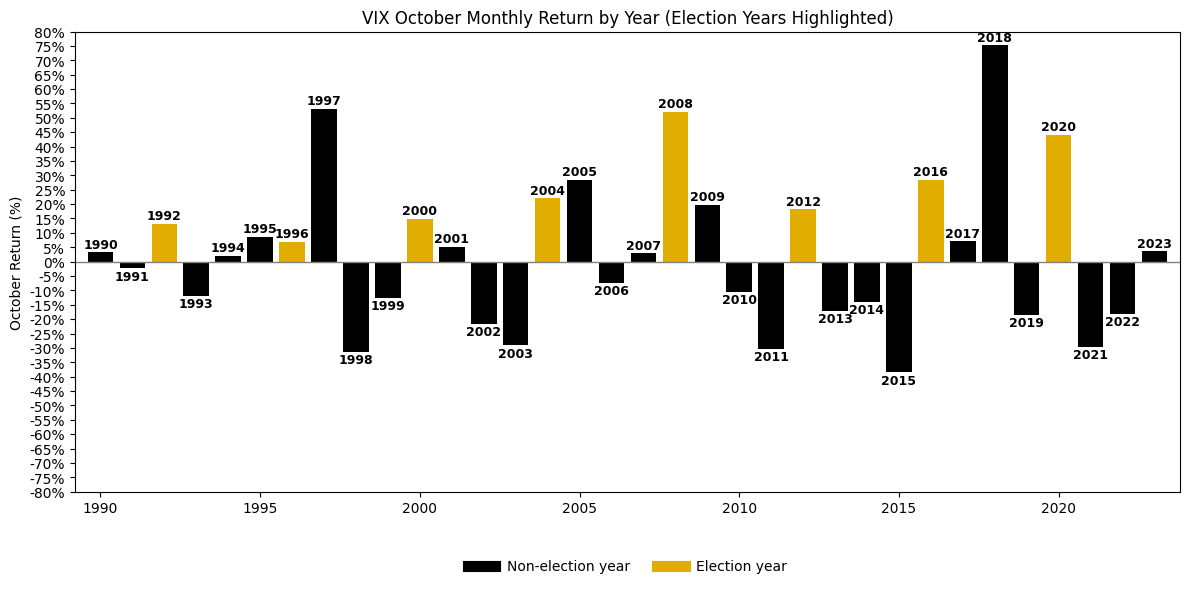

In [3]:
# Chart colors
BLACK = "#000000"
YELLOW = "#E1AD01"

years = oct_returns["Year"].values
rets = oct_returns["OctReturn"].values
is_elect = oct_returns["ElectionYear"].values.astype(bool)

colors = np.where(is_elect, YELLOW, BLACK)

# Y-axis range
max_abs = np.max(np.abs(rets)) if len(rets) else 0.10
tick_step = 0.05
ylim = ceil(max_abs / tick_step) * tick_step
ylim = max(ylim, 0.10)

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(years, rets, color=colors, edgecolor="none")

# Add year labels
for y, r in zip(years, rets):
    ax.text(
        y,
        r + (0.005 if r >= 0 else -0.005),
        f"{y}",
        ha="center",
        va="bottom" if r >= 0 else "top",
        color="black",
        fontsize=9,
        rotation=0,
        fontweight="bold"
    )

# Formatting
ax.axhline(0, color="gray", linewidth=1)
ax.set_xlim(years.min()-0.8, years.max()+0.8)
ax.set_ylabel("October Return (%)")
ax.set_title("VIX October Monthly Return by Year (Election Years Highlighted)")
ax.yaxis.set_major_locator(MultipleLocator(tick_step))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
ax.set_ylim(-ylim, ylim)

# Add legend
handles = [
    plt.Line2D([0], [0], color=BLACK, lw=8, label="Non-election year"),
    plt.Line2D([0], [0], color=YELLOW, lw=8, label="Election year"),
]
ax.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

<h3> Compute Summary Statistics (All vs Election)

In [4]:
def pct_positive(x):
    return (x > 0).mean()

# All Octobers
avg_all = oct_returns["OctReturn"].mean()
pctpos_all = pct_positive(oct_returns["OctReturn"])

# Election Octobers
e_mask = oct_returns["ElectionYear"] == 1
avg_elec = oct_returns.loc[e_mask, "OctReturn"].mean()
pctpos_elec = pct_positive(oct_returns.loc[e_mask, "OctReturn"])

# Build table
summary_tbl = pd.DataFrame({
    "All years": [avg_all, pctpos_all],
    "Election years": [avg_elec, pctpos_elec],
}, index=["Avg return", "Pct positive return"])

# Format table for display
summary_format = summary_tbl.copy()
for col in summary_format.columns:
    summary_format[col] = [
        f"{v*100:.2f}%" if i == "Avg return" else f"{v*100:.1f}%"
        for i, v in zip(summary_format.index, summary_tbl[col].values)
    ]

summary_format

,All years,Election years
Avg return,3.40%,24.95%
Pct positive return,55.9%,100.0%


<h3> Interpretation of Statistics

On average, October shows a modest VIX increase of about 3.4%, meaning volatility typically rises slightly during this month. In contrast, during election years, the VIX surges by nearly 25% on average, with every election October posting a gain. This indicates that political uncertainty tends to drive a much stronger and more consistent spike in market volatility.

<h3> Model: Do Election Years Predict October Returns?

Given the promise of the basic computations, I chose to test whether the ElectionYear dummy predicts October VIX performance. OLS: dependent variable = October return (continuous). Logit: dependent variable = 1{October return > 0}.

I report coefficients, p-values, R² (for OLS) or accuracy (for Logit), 95% confidence intervals, and odds ratios (for Logit). An additional OLS specification includes a control for SepEndVIX level to account for baseline volatility conditions entering October.

In [5]:
# Prepare modeling frame
mod_df = oct_returns.dropna(subset=["OctReturn", "ElectionYear"]).copy()
mod_df["Pos"] = (mod_df["OctReturn"] > 0).astype(int)

# OLS: OctReturn ~ ElectionYear
ols1 = smf.ols("OctReturn ~ ElectionYear", data=mod_df).fit()

# Control: SepEndVIX
ols2 = smf.ols("OctReturn ~ ElectionYear + SepEndVIX", data=mod_df).fit()

# Logistic: Pos ~ ElectionYear
logit1 = smf.logit("Pos ~ ElectionYear", data=mod_df).fit(disp=False)

# Summaries and key metrics
def ci_frame(res, alpha=0.05):
    ci = res.conf_int(alpha=alpha)
    ci.columns = ["CI Lower", "CI Upper"]
    return ci

print("=== OLS: OctReturn ~ ElectionYear ===")
print(ols1.summary())
print("\n95% CI:\n", ci_frame(ols1))

print("\n=== OLS (with SepEndVIX control) ===")
print(ols2.summary())
print("\n95% CI:\n", ci_frame(ols2))

print("\n=== LOGIT: Pos ~ ElectionYear ===")
print(logit1.summary())
print("\n95% CI (coeffs):\n", ci_frame(logit1))

# Convert logit coefficients to odds ratios with confidence intervals
odds = np.exp(logit1.params)
odds_ci = np.exp(logit1.conf_int())
odds_df = pd.DataFrame({"OddsRatio": odds, "CI Lower": odds_ci[0], "CI Upper": odds_ci[1]})
print("\nOdds Ratios (exp(coeff)):\n", odds_df)

# Run in-sample accuracy for logistic
pred_prob = logit1.predict(mod_df)
pred_class = (pred_prob >= 0.5).astype(int)
accuracy = (pred_class == mod_df["Pos"]).mean()
print(f"\nLogistic in-sample accuracy: {accuracy:.3f}")

=== OLS: OctReturn ~ ElectionYear ===
                            OLS Regression Results                            
Dep. Variable:              OctReturn   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     8.383
Date:                Tue, 14 Oct 2025   Prob (F-statistic):            0.00677
Time:                        19:45:42   Log-Likelihood:                 1.1953
No. Observations:                  34   AIC:                             1.609
Df Residuals:                      32   BIC:                             4.662
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept 

/Users/ethanogrodniczuk/Library/Python/3.13/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h3> Model Observations

The ElectionYear coefficient in the OLS specification is positive (0.2819) and statistically significant (p = 0.007), indicating that, on average, October VIX returns are approximately 28 percentage points higher in election years relative to non-election years. The magnitude of this effect remains largely unchanged when controlling for SepEndVIX, suggesting that the relationship is not driven by elevated baseline volatility going into October.

In the logit model, the odds ratio for ElectionYear exceeds one, implying that the likelihood of observing a positive October VIX return increases materially in election years, consistent with heightened political risk premia and uncertainty pricing.

While the sample size remains limited (N = 33), the inclusion of eight election cycles spanning 1990-2020 provides meaningful variation in macroeconomic and market conditions — offering a reasonable stress test for the robustness of the relationship. Nonetheless, potential OVB and evolving volatility regimes over time warrant cautious interpretation of the magnitude of the effect.

<h3> Bootstrap Confidence Intervals (Robustness)

In this setup, I use non-parametric boostrapping to assess the stability of the mean October return estimates without assuming normality. I repeatedly (10,000 times) resample the observed data with replacement and compute the mean October return for each resample. This process is done for: all Octobers, election Octobers, and non-election Octobers.

By examining the 95% confidence intervals from these bootstrap distributions, I can evaluate how sensitive the estimated mean returns are to sample variations — providing a more robust measure of uncertainty around the averages, especially given the small sample size and potential non-normality in returns.

In [6]:
def bootstrap_mean_ci(x, n_iter=10_000, alpha=0.05):
    x = np.asarray(x).astype(float)
    n = len(x)
    if n == 0:
        return np.nan, (np.nan, np.nan)
    draws = np.random.choice(x, size=(n_iter, n), replace=True)
    means = draws.mean(axis=1)
    lower = np.percentile(means, 100*alpha/2)
    upper = np.percentile(means, 100*(1 - alpha/2))
    return means.mean(), (lower, upper)

all_mean, all_ci = bootstrap_mean_ci(oct_returns["OctReturn"].dropna())
elec_mean, elec_ci = bootstrap_mean_ci(oct_returns.loc[oct_returns["ElectionYear"]==1, "OctReturn"].dropna())
nonelec_mean, nonelec_ci = bootstrap_mean_ci(oct_returns.loc[oct_returns["ElectionYear"]==0, "OctReturn"].dropna())

boot_tbl = pd.DataFrame({
    "Group": ["All Octobers", "Election Octobers", "Non-Election Octobers"],
    "Boot Mean": [all_mean, elec_mean, nonelec_mean],
    "CI Lower": [all_ci[0], elec_ci[0], nonelec_ci[0]],
    "CI Upper": [all_ci[1], elec_ci[1], nonelec_ci[1]],
})

# Print as percentages
boot_format = boot_tbl.copy()
for col in ["Boot Mean", "CI Lower", "CI Upper"]:
    boot_format[col] = boot_format[col].apply(lambda v: f"{v*100:.2f}%")
boot_format

,Group,Boot Mean,CI Lower,CI Upper
0,All Octobers,3.42%,-5.16%,12.58%
1,Election Octobers,24.97%,15.38%,35.77%
2,Non-Election Octobers,-3.27%,-12.47%,6.99%


<h3> Bootstrap Interpretation

The bootstrap confidence intervals indicate that only election-year Octobers exhibit a mean return statistically distinguishable from zero — the 95% CI (15.4%, 35.8%) excludes zero entirely. In contrast, both all Octobers and non-election Octobers have confidence intervals spanning zero, implying no statistically significant average move in those subsets. 

The election-year CI is both higher in level and tighter in relative terms, suggesting not only larger but also more consistently positive VIX responses during election periods. This provides further evidence of structurally different October dynamics under election-related uncertainty, consistent with heightened volatility risk premia priced into options markets during those years.

<h3> Conclusion

This project reflects my effort to bridge empirical analysis with macroeconomic financial insight, translating uncertainty in political cycles into measurable signals in volatility markets. By isolating October, a historically pivotal month for risk repricing, and evaluating its behaviour across U.S. presidential election years, this analysis connects political transition risk to systematic movements in implied volatility.

The findings are statistically and economically significant: October VIX performance averages roughly 25% in election years versus about 3% otherwise, with every election-year October posting a positive return. The regression results reinforce this relationship, with election years correspond to roughly 28 percentage points higher October VIX returns (p = 0.007), independent of baseline volatility conditions. Non-parametric bootstrapping further confirms that only election-year Octobers exhibit a mean return distinguishable from zero at the 95% confidence level, demonstrating both the strength and consistency of the effect.

The broader implication is that political uncertainty systematically alters volatility pricing. Markets do not merely react to elections, they anticipate and price in the risk of regime change through heightened demand for protection, reflected directly in volatility instruments. This interplay between macroeconomic uncertainty, investor psychology, and derivative markets captures how non-economic shocks transmit quantifiable financial outcomes.

This work illustrates my data-driven approach to connecting theory with market reality: building hypotheses from macroeconomic intuition, testing them empirically, and evaluating robustness through statistical resampling. It reflects an analytical framework grounded in curiosity, using econometric tools to uncover the structural patterns behind complex market phenomena. Lastly, this project demonstrates my research philosophy centered on disciplined reasoning, empirical precision, and a global macroeconomic lens; an approach that aligns naturally with the way leading quantitative and macro hedge funds seek to interpret and trade the world's uncertainty.

*Reproduction Notes:*

- Data source: *vix_data_raw.xlsx* (close prices at daily frequency).
- October return definition uses last trading day of September and October for each year.
- Election years highlighted: 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020.
- Models estimated with statsmodels. Bootstrap uses 10,000 resamples with replacement.